# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import math
np.random.seed()
import matplotlib.pyplot as plt
from scipy import stats

# Methods for different Questions

In [3]:
class stock:
    def __init__(self,s0,r,vol,maturity):
        self.s0 = s0
        self.r = r
        self.vol = vol
        self.maturity = maturity
    
    def FDMBarrierUpandOut(self,dt,ds,barrier,strike):
        s_infinity = np.arange(0,barrier+2,ds)
        NoofTimesteps = int(self.maturity/dt)
        NoofStockprices = int(len(s_infinity))
        FDM_grid = np.zeros((NoofTimesteps,NoofStockprices))
        FDM_grid[len(FDM_grid)-1] = np.array(list(map(lambda x: max(x-strike,0) if x <= barrier else 0,s_infinity)))
        for i in range(len(FDM_grid)-1)[::-1]:
            for j in range(1,len(FDM_grid[i])-1):
                delta = (FDM_grid[i+1][j+1]-FDM_grid[i+1][j-1])/(2*ds)
                gamma = (FDM_grid[i+1][j+1]+FDM_grid[i+1][j-1]-(2*FDM_grid[i+1][j]))/(ds**2)
                FDM_grid[i][j] = FDM_grid[i+1][j] - dt*((self.r*FDM_grid[i+1][j]) - (self.r*s_infinity[j]*delta) - (0.5 * self.vol**2 * s_infinity[j]**2 * gamma))
            FDM_grid[i][0] = FDM_grid[i+1][0]*(1-self.r*dt)
            #FDM_grid[i][-1] = 2*FDM_grid[i][-2] - FDM_grid[i][-3]
        prices = pd.DataFrame(FDM_grid,index=np.arange(0,self.maturity,dt),columns=s_infinity)
        return prices[self.s0][0]
  
    def BlackScholesCall(self,StrikePrice):
        d1 = ((math.log((self.s0 )/ StrikePrice) + (self.r + 0.5 * self.vol ** 2) * self.maturity)
        / (self.vol * math.sqrt(self.maturity)))
        d2 = d1 - self.vol*(math.sqrt(self.maturity))
        Nd1 = stats.norm.cdf(d1,0,1)
        Nd2 = stats.norm.cdf(d2,0,1)
        return self.s0 * Nd1 - StrikePrice * np.exp(-self.r * self.maturity) * Nd2
    
    def BarrierAnalytical(self,barrier,strike):
        lamda = (self.r + ((self.vol**2)/2))/(self.vol**2)
        y = math.log((barrier**2)/(self.s0*strike))/(self.vol*np.sqrt(self.maturity)) + lamda*self.vol*np.sqrt(self.maturity)
        x1 = (math.log(self.s0/barrier)/(self.vol*np.sqrt(self.maturity)))+(lamda*self.vol*np.sqrt(self.maturity))
        y1 = (math.log(barrier/self.s0)/(self.vol*np.sqrt(self.maturity)))+(lamda*self.vol*np.sqrt(self.maturity))
        x1sigma = x1 - (self.vol*np.sqrt(self.maturity))
        ysigma = -y + self.vol*np.sqrt(self.maturity)
        y1sigma = -y1 + self.vol*np.sqrt(self.maturity)
        Nx1 = stats.norm.cdf(x1,0,1)
        Nnegy = stats.norm.cdf(-y,0,1)
        Nnegy1 = stats.norm.cdf(-y1,0,1)
        Nx1sigma = stats.norm.cdf(x1sigma,0,1)
        Nysigma = stats.norm.cdf(ysigma,0,1)
        Ny1sigma = stats.norm.cdf(y1sigma,0,1)
        Cui = (self.s0*Nx1) - (strike*np.exp(-self.r*self.maturity)*Nx1sigma) - (self.s0*((barrier/self.s0)**(2*lamda))*(Nnegy - Nnegy1)) + (strike*np.exp(-self.r*self.maturity)*((barrier/self.s0)**(2*lamda-2))*(Nysigma - Ny1sigma))                  
        Cuo = stock.BlackScholesCall(self,strike) - Cui
        return Cuo

# Question 1:

Implement the analytical formula for an Up & Out call with barrier at maturity.

In [8]:
spot = 300
r = 0.02
volatility = 0.2
maturity = 0.25
strike = 320
barrier = 400
GivenStock = stock(spot,r,volatility,maturity)
analytical_price = GivenStock.BarrierAnalytical(barrier,strike)
analytical_price

4.927744392408185

# Question 2

Plot the graph displaying the option value with respect to the spot for a given barrier.

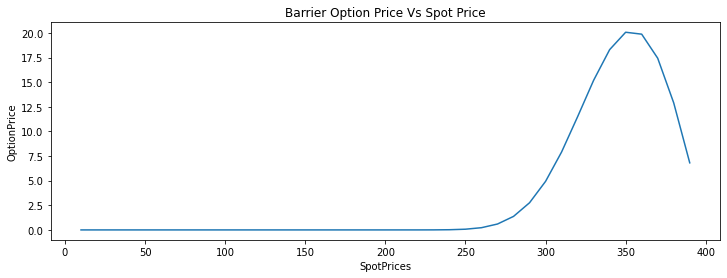

In [203]:
SpotPrices = np.arange(10,barrier,10)
OptionPrices = []
for i in SpotPrices:
    temp_stock = stock(i,r,volatility,maturity)
    OptionPrices.append(temp_stock.BarrierAnalytical(barrier,strike))
plt.figure(figsize=(12,4))
plt.plot(SpotPrices,OptionPrices)
plt.xlabel('SpotPrices')
plt.ylabel('OptionPrice')
plt.title('Barrier Option Price Vs Spot Price')
plt.show()

# Question 3

Implement the pricing of the same Barrier option using an explicit PDE scheme.

In [9]:
dt = 0.0001
ds = 2
BarrierPrice_FDM = GivenStock.FDMBarrierUpandOut(dt,ds,barrier,strike)
BarrierPrice_FDM

4.920552012753565

# Question 4

Show the numerical scheme instability when time and space dis- cretization parameters are not suitable.

One of the constraints with respect to dt is that $ dt \leqslant 1 \div (\sigma^2 * (barrier/ds)^2)$. So, with $\sigma = 0.2$, $ barrier = 400$ and $ds = 2$, dt should be less than 0.000625. To show the instability, we took dt = 0.001

In [205]:
dt = 0.001
ds = 2
BarrierPrice_FDM = GivenStock.FDMBarrierUpandOut(dt,ds,barrier,strike)
BarrierPrice_FDM

-5.9628923870856e+55

As it can be observed, the price is very abnormal

# Question 5

Show that for well chosen time and space discretization parameters, the PDE and analytical prices match.

From the above question, inorder to choose a good time and Space discretization parameters, $dt \leqslant 0.000625$

In [207]:
dt = 0.0001
ds = 2
print(f' Analytical Price of the Up and Out Barrier call option is {GivenStock.BarrierAnalytical(barrier,strike)}')
print(f' PDE Price of the Up and Out Barrier call option is {GivenStock.FDMBarrierUpandOut(dt,ds,barrier,strike)}')

 Analytical Price of the Up and Out Barrier call option is 4.927744392408185
 PDE Price of the Up and Out Barrier call option is 4.920552012753565


# Question 6

Greeks for analytical price

In [208]:
def greeksAnalytical(dt,ds,spot):
    stock2 = stock(spot+ds,r,volatility,maturity)
    stock1 = stock(spot-ds,r,volatility,maturity)
    spotstock = stock(spot,r,volatility,maturity)
    forwardstock = stock(spot,r,volatility,maturity-dt)
    delta = (stock2.BarrierAnalytical(barrier,strike) - stock1.BarrierAnalytical(barrier,strike))/(2*ds)
    gamma = (stock2.BarrierAnalytical(barrier,strike) + stock1.BarrierAnalytical(barrier,strike) - (2*(spotstock.BarrierAnalytical(barrier,strike))))/(2*ds)
    Theta = (forwardstock.BarrierAnalytical(barrier,strike) - spotstock.BarrierAnalytical(barrier,strike))/(dt)         
    return print(f'Delta,Gamma and Theta are:{(delta,gamma,Theta)}')

In [209]:
greeksAnalytical(0.0001,2,300)

Delta,Gamma and Theta are is:(0.2587638263186498, 0.00830851586583492, -16.428731674080765)


In [210]:
def greeksFDM(dt,ds,spot):
    stock2 = stock(spot+ds,r,volatility,maturity)
    stock1 = stock(spot-ds,r,volatility,maturity)
    spotstock = stock(spot,r,volatility,maturity)
    forwardstock = stock(spot,r,volatility,maturity-dt)
    delta = (stock2.FDMBarrierUpandOut(dt,ds,barrier,strike) - stock1.FDMBarrierUpandOut(dt,ds,barrier,strike))/(2*ds)
    gamma = (stock2.FDMBarrierUpandOut(dt,ds,barrier,strike) + stock1.FDMBarrierUpandOut(dt,ds,barrier,strike) - (2*(spotstock.FDMBarrierUpandOut(dt,ds,barrier,strike))))/(2*ds)
    Theta = (forwardstock.FDMBarrierUpandOut(dt,ds,barrier,strike) - spotstock.FDMBarrierUpandOut(dt,ds,barrier,strike))/(dt)         
    return print(f'Delta,Gamma and Theta are:{(delta,gamma,Theta)}')

In [211]:
greeksFDM(0.0001,2,300)

Delta,Gamma and Theta are is:(0.2585744806915051, 0.008318648762706715, -16.43496458496152)


Greeks from FDM and the Analytical Pricer are almost similar